In [ ]:
import warnings
import pandas as pd
import os
import plotly.express as px
from IPython.display import Image
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns

pd.set_option("display.max_columns", None)

In [23]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
plt.rcParams.update({"axes.grid": True})
# mpl.rcParams.update({"axes.grid": True})
sns.set()

In [8]:
df = pd.read_csv(
    "./data/mammoth_mountain_snowfall_melted_table_with_monthly_average.csv"
)
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")
df

,Month,Snow Fall,MonthlyAverage
Date,,,
1970-01-01,Jan,78.0,71.333333
1970-02-01,Feb,30.5,69.761111
1970-03-01,Mar,46.0,63.718519
1970-04-01,Apr,27.0,32.924074
1970-05-01,May,0.0,8.029630
...,...,...,...
2023-08-01,Aug,0.0,2.870370
2023-09-01,Sep,0.0,2.870370
2023-10-01,Oct,0.0,6.372222


In [9]:
df = df.reindex(pd.date_range(start=df.index[0], periods=len(df), freq="MS"))
df.index.set_names("Date", inplace=True)
df

,Month,Snow Fall,MonthlyAverage
Date,,,
1970-01-01,Jan,78.0,71.333333
1970-02-01,Feb,30.5,69.761111
1970-03-01,Mar,46.0,63.718519
1970-04-01,Apr,27.0,32.924074
1970-05-01,May,0.0,8.029630
...,...,...,...
2023-08-01,Aug,0.0,2.870370
2023-09-01,Sep,0.0,2.870370
2023-10-01,Oct,0.0,6.372222


In [10]:
df_small = df["2010":][["Snow Fall"]]
df_small.head()

,Snow Fall
Date,
2010-01-01,127.0
2010-02-01,108.0
2010-03-01,62.5
2010-04-01,84.9
2010-05-01,17.5


In [14]:
df_small_daily_interp = df_small.reindex(
    pd.date_range(start=df_small.index[0], end=df_small.index[-1], freq="D")
).interpolate(method="spline", order=4)

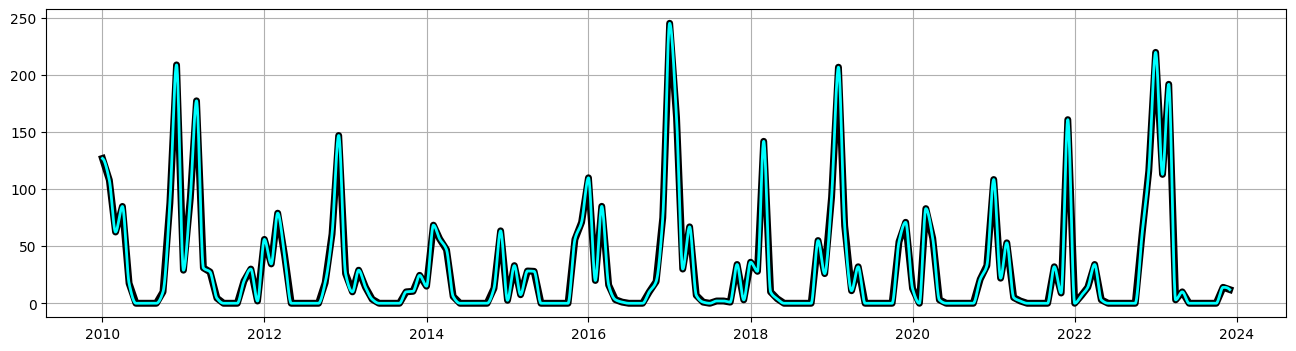

In [12]:
plt.figure(figsize=(16, 4))
plt.plot(df_small["Snow Fall"], color="black", lw=5)
plt.plot(df_small_daily_interp["Snow Fall"], color="cyan", lw=2)
plt.grid()

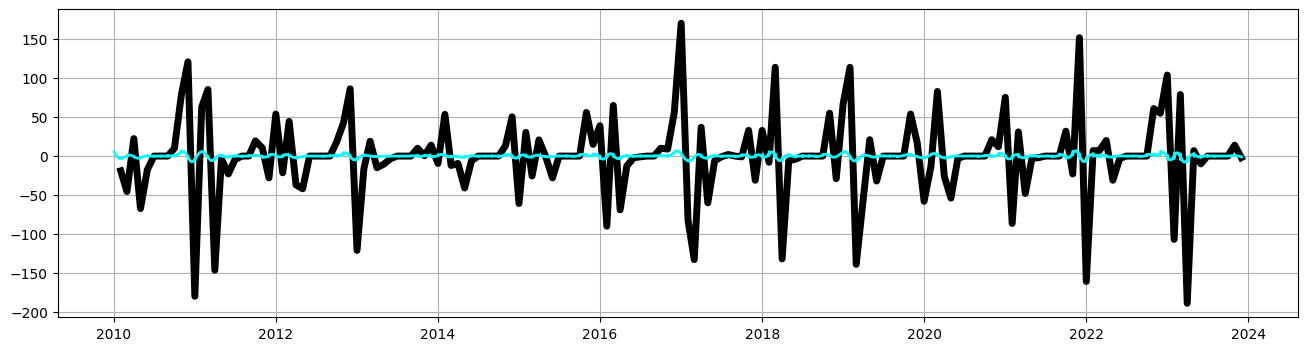

In [18]:
plt.figure(figsize=(16, 4))
plt.plot(df_small["Snow Fall"].diff(), color="black", lw=5)
plt.plot(df_small_daily_interp["Snow Fall"].diff(), color="cyan", lw=2)
plt.grid()

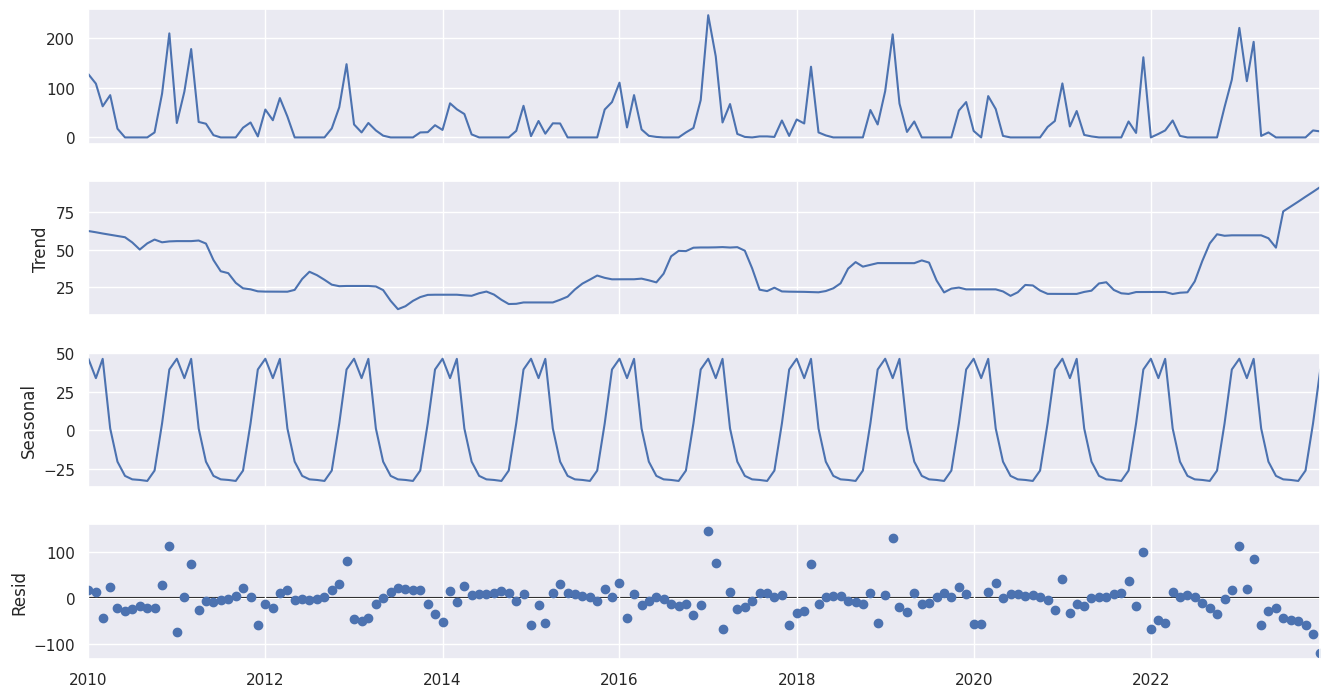

In [25]:
snowfall_period = 12
seasonal_decompose(
    df_small,
    model="additive",
    period=snowfall_period,
    extrapolate_trend=snowfall_period,
).plot(observed=True).set_size_inches((15, 7.5))

plt.show()

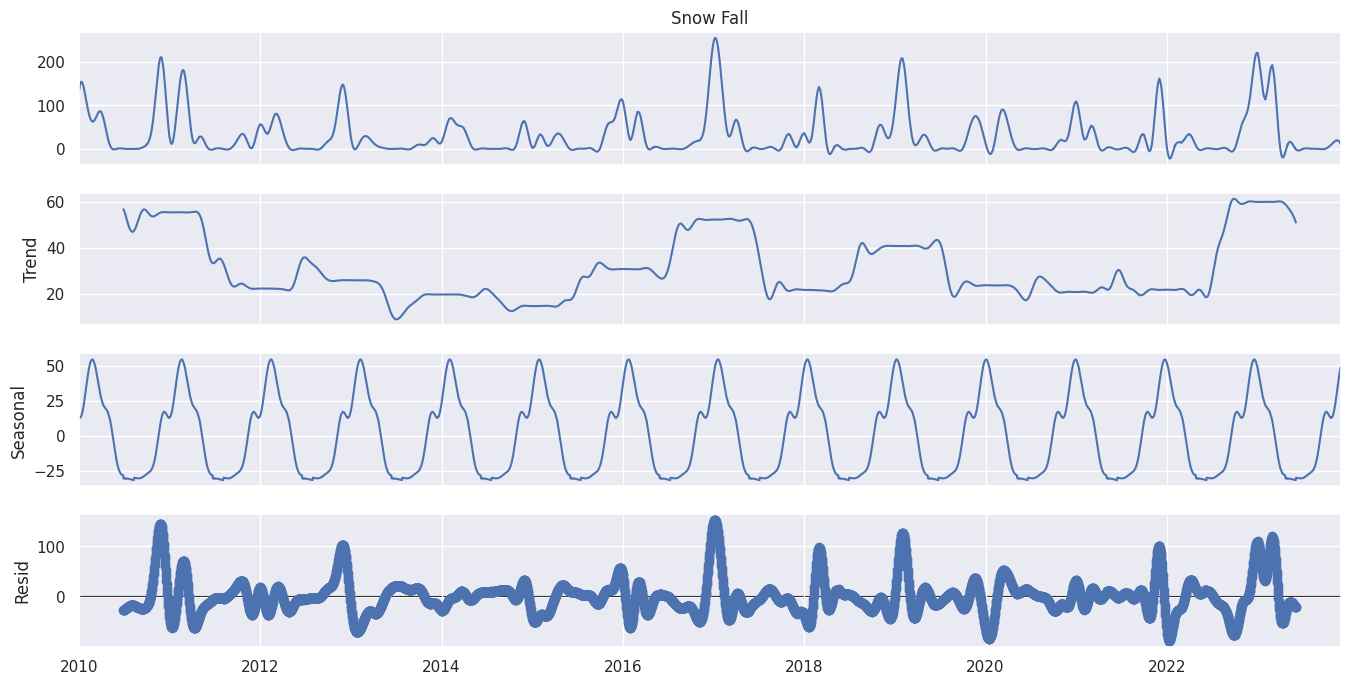

In [46]:
daily_snowfall_period = 12 * 30
seasonal_decompose(
    df_small_daily_interp["Snow Fall"],
    model="additive",
    period=daily_snowfall_period,
).plot(observed=True).set_size_inches((15, 7.5))

plt.show()

In [29]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict

In [32]:
def plot_acf_pacf(y):
    (fig, ax) = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
    plot_acf(y, ax=ax[0])
    ax[0].set_title("ACF - MA(q)")
    ax[0].set_xlabel("Lag")
    ax[0].set_ylabel("Corr")

    plot_pacf(y, ax=ax[1])
    ax[1].set_title("PACF - AR(p)")
    ax[1].set_xlabel("Lag")
    ax[1].set_ylabel("Corr")
    plt.show()

In [58]:
y_target = df_small_daily_interp["Snow Fall"]["2021":]

In [59]:
# plot_acf_pacf(y_target)

In [60]:
n_train = int(0.75 * len(y_target))
n_test = len(y_target) - n_train
[n_train, n_test]

[798, 267]

In [64]:
y_target.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 1065 entries, 2021-01-01 to 2023-12-01
Freq: D
Series name: Snow Fall
Non-Null Count  Dtype  
--------------  -----  
1065 non-null   float64
dtypes: float64(1)
memory usage: 16.6 KB


In [61]:
y_history, y_future = y_target.head(n_train), y_target.tail(n_test)

In [62]:
order = (1, 0, 1)
seasonal_order = (1, 0, 1, daily_snowfall_period)

In [63]:
estimator = ARIMA(
    y_history,
    order=order,
    seasonal_order=seasonal_order,
).fit()

# Predict history and future
y_hat = estimator.predict(start=y_history.index[0], end=y_future.index[-1])

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(16, 4))

plt.plot(
    y_target,
    color="black",
    label="Observed",
    linestyle="solid",
    marker="o",
    lw=5,
)

plt.plot(
    y_hat,
    color="cyan",
    label="Fit and Forecast",
    linestyle="solid",
    lw=5,
)